<a id="intro"></a>
# Исследование продаж компьютерных игр

**Описание проекта**

Заказчик — интернет-магазин «Стримчик». 

От заказчика получены исторические данные о продажах игр, оценках пользователей и экспертов, жанров и платформ (например, Xbox или PlayStation). Необходимо выявить закономерности, определяющие успешность игр. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Данные представлены до 2016 года. Нужно отработать принцип работы с данными. В независимости от планируемого периода - продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года. Данные за 2016 год могут быть неполными.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

**Цели исследования**:
1. [Выяснить актуальный период для анализа и планирования продаж](#analysis_year)
2. [Выяснить растущие, снижающиеся и потенциально прибыльные платформы](#sales_platform)
3. [Определить зависимость продаж от оценки пользователей и критиков](#sales_score)
4. [Оценить популярность и прибыльность жанров](#sales_genre)
5. [Изучить платформы, жанры и рейтинг ESRB в регионах NA, EU, JP](#regions)
6. [Проверить гипотезы о платформах и жанрах](#testing_hypos)

 👉 **[Итоги исследования здесь](#research_results)**

**Описание данных**

- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB

## Общая информация о данных

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import os
import seaborn as sns
import numpy as np
import scipy.stats as st
import warnings

In [2]:
# чтение файла с данными и сохранение в соответствующие датафреймы
dir1 = '/datasets/'
dir2 = '/Users/alexslobodskoj/Data_Analyst/'
data_pth = 'games.csv'

if os.path.exists(dir1):
    data = pd.read_csv(dir1 + data_pth)
elif os.path.exists(dir2):
    data = pd.read_csv(dir2 + data_pth)
else:
    print('Something is wrong')

In [3]:
# вывод первых 5 строк 
display(data.head())

# вывод основной информации
data.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


<div style="border:solid gray 1px; padding: 20px">

**Выводы:**
- необходимо привести к нижнему регистру названия всех столбцов
- в таблице есть пропущенные значения
- в столбцах `Year_of_Release`, `User_Score` необходимо изменить тип данных
- необходимо проверить таблицу на наличие дубликатов

## Предобработка данных

### Переименование столбцов

In [4]:
# приведение наименований всех столбцов к нижнему регистру
data.columns = data.columns.str.lower()

### Удаление пропусков

Пропущенные значения обнаружены в следующих столбцах:

In [5]:
# создание Series столбцов с признаком пропущенных значений
bool_series = data.isna().sum() > 0

# вывод названий столбцов с пропусками и количества пропусков
data.isna().sum()[bool_series]

name                  2
year_of_release     269
genre                 2
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Рассчитаем процент пропущенных значений.

In [6]:
# вывод информации о доле пропущенных значений
data_na = pd.DataFrame(data.isna().mean()[bool_series])
data_na.style.format("{:.2%}").background_gradient('coolwarm')

,0
name,0.01%
year_of_release,1.61%
genre,0.01%
critic_score,51.32%
user_score,40.09%
rating,40.48%


**Название и жанр**

Исключим две строки с пропущенными значениями в столбцах `name` и `genre` из дальнейшего анализа.

In [7]:
# оставляем в `data` строки c существующими значениями в `name`
data = data.query('name.notna()')

**Год выпуска**

Предположим, что некоторые игры выходили на разных платформах и в разные годы. Заполним пропущенные значения в столбце `year_of_release` медианными значениями года выпуска по каждой игре.

In [8]:
# формирование датафрейма с пропущенными значениями
data_filtered = data.query('year_of_release.isna()')

# заполнение пропущенных значений в столбце `year_of_release` медианными значениями из `name`
data.loc[data_filtered.index, 'year_of_release'] = \
(
    data
    .groupby(['name'])['year_of_release']
    .transform('median')
)
# вывод количества пропущенных значений в `year_of_release`
display(
    Markdown(
        f'Осталось **{data["year_of_release"].isna().sum()}** строк с пропущенными значениями в `year_of_release` ')
)

Осталось **146** строк с пропущенными значениями в `year_of_release` 

**Оценка критиков**

Заполнение пропущенных значений в столбцах `critic_score` медианными или средними значениями из других платформ нецелесообразно. Каждая платформа имеет свои особенности и требования, которые могут повлиять на восприятие игры и оценку.

**Рейтинг ESRB**

Заполним пропущенные значения в столбце `rating` первыми значениями моды по каждой игре, если у нее есть какой-либо рейтинг.

In [9]:
# функция для заполнения пропущенных значений значением моды
def fillna_mode(x):
    if x.notna().any():
        mode_value = x.mode()[0]
        return mode_value
    else:
        return x

# заполнение пропусков в столбце rating значениями моды 
data['rating'] = \
(
    data
    .groupby('name')['rating']
    .transform(fillna_mode)
)    

**Оценка пользователей**

Оценим количество строк со значением `tbd` в `user_score`

In [10]:
# формирование датафрейма с `tbd` значениями
data_filtered = data.query('user_score == "tbd"')
                           
# вывод количества пропущенных значений в `year_of_release`
display(
    Markdown(
        f'В таблице **{data_filtered["user_score"].count()}** строки с `tbd` значениями в `user_score` ')
)

В таблице **2424** строки с `tbd` значениями в `user_score` 

Аббревиатура “tbd” обычно расшифровывается как “to be determined” (будет определено) и указывает на то, что оценка для данной игры ещё не определена или не установлена. Так как по сути `tbd` значения в `user_score` это и есть `NaN`, то заменим `tbd` значения на `NaN`

In [11]:
# замена `tbd` значений в `user_score` на `NaN`
data['user_score'] = data['user_score'].replace('tbd', np.nan)

### Изменение типа данных

**Год выпуска**

Изменим `float64` тип столбца `year_of_release` на целочисленный - значение года не может быть дробным числом.

In [12]:
# изменение типа данных в `year_of_release` на целочисленный
data['year_of_release'] = \
(
    data['year_of_release']
    .round()
    .astype(pd.Int64Dtype())
)

**Оценка пользователей**

Для возможности дальнейшего анализа изменим строковый тип столбца `user_score` на `float64`

In [13]:
# изменение типа данных в `user_score` на `float64`
data['user_score'] = data['user_score'].astype('float64')

### Добавление нового столбца

Добавим столбец `total_sales` как сумму продаж по всем регионам

In [14]:
# добавление столбца `total_sales`
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

### Проверка наличия дубликатов

Проверим наличие явных дубликатов

In [15]:
# вывод информации о дубликатах
if data.duplicated().sum() > 0:
    display(
        Markdown(
            f'**{data.duplicated().sum()}**'
            f' явных дубликатов строк')
    )
else:
    display(
        Markdown(
            f'Нет явных дубликатов')
    )

Нет явных дубликатов

Проверим наличие неявных дубликатов в столбцах `platform`, `genre`, `rating`

In [16]:
# вывод отсортированного уникального списка значений в 'platform'
display(data['platform'].sort_values().unique())

# вывод отсортированного уникального списка значений в 'genre'
display(data['genre'].sort_values().unique())

# вывод отсортированного уникального списка значений в 'rating'
display(data['rating'].sort_values().unique())

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object)

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy'], dtype=object)

array(['E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T', nan], dtype=object)

Неявных дубликатов в столбцах `platform`, `genre`, `rating` не обнаружено.

Проверим наличие дубликатов в сочетании столбцов `name + platform + year_of_release`. Суммируем количество продаж по дубликатам. Значения оценок и рейтинга возьмем из первого значения.

In [17]:
# запись дублей `name` в переменную data_agg
data_agg = data.groupby(['name', 'platform', 'year_of_release'])['name'].transform('size') > 1

# запись в переменную data_agg датафрейма с дублями `name`
data_agg = data[data_agg].sort_values(by='name')

# группировка дублей в одну строку по каждой группе `name + platform + year_of_release`
data_agg = \
(
    data_agg
    .groupby(['name', 'platform', 'year_of_release'])
    .agg(
        na_sales=('na_sales', 'sum'),
        eu_sales=('eu_sales', 'sum'),
        jp_sales=('jp_sales', 'sum'),
        other_sales=('other_sales', 'sum'),
        total_sales=('total_sales', 'sum'),
        genre=('genre', 'first'),
        critic_score=('critic_score', 'first'),
        user_score=('user_score', 'first'),
        rating=('rating', 'first'),
        first_index=('name', lambda x: x.index[0]))
    .reset_index()
    .set_index('first_index')
)

# удаление всех строк с дублями из `data`
data.drop_duplicates(subset=['name', 'platform', 'year_of_release'], inplace=True, keep=False)

# добавление сгруппированных строк по дублям
data = pd.concat([data, data_agg])

<div style="border:solid gray 1px; padding: 20px">

**Выводы**
- названия столбцов приведены к нижнему регистру
- пропущенные и `tbd` значения обработаны
- вероятно пропущенные значения возникли из-за отсутствия данных в открытых источниках или невозможности "сборщика данных" считать их
- изменен тип данных в двух столбцах
- в таблице нет явных дубликатов, неявные дубликаты обработаны
- добавлен столбец с суммой продаж по всем регионам


<a id="data_analysis"></a>
## Исследовательский анализ данных

<a id="analysis_year"></a>
### Анализ выпуска игр по годам

Построим гистограмму распределения количества игр по годам

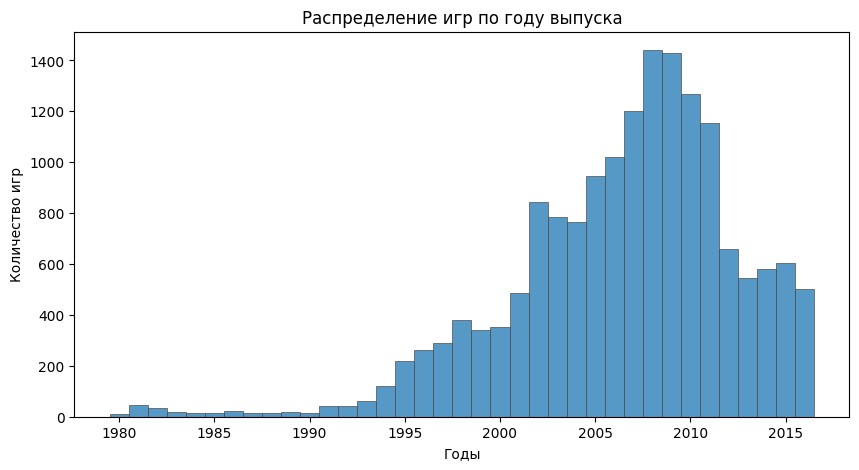

In [18]:
# вывод гистограммы
plt.figure(figsize=(10, 5))
sns.histplot(
    data,
    x="year_of_release", 
    edgecolor=".3",
    linewidth=.5,
    discrete=True,
)
plt.title('Распределение игр по году выпуска')
plt.ylabel('Количество игр')
plt.xlabel('Годы')
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы**
1. В период с 1990 по 2009 гг. произошел значительный технологический прогресс в области компьютерных и консольных игр. Увеличению выпуска игр способствовали
- появление 3D-графики,
- улучшение процессоров и видеокарт,
- развитие технологий хранения данных
  
2. В период с 2010 по 2011 гг. произошло резкое снижение выпуска компьютерных игр вероятно вследствие влияние мирового финансового кризиса и переход индустрии от традиционного развития игр к онлайн и мобильным играм.
    
  
3. В период с 2012 по 2016 гг. рынок стабилизировался - баланс спроса и предложения в новых условиях:
- индустрия адаптировалась к онлайн и мобильным предпочтениям геймеров
- студии адаптировались к новым возможностям техногий виртуальной реальности и улучшенных графических движков

### Анализ "жизненного цикла" платформ

Оценим количество суммарных продаж по платформам для выбора Топ-5 платформ

In [19]:
# создание `data_agg` с агрегированными данными
data_agg = \
(
    data
    .groupby('platform')
    .agg({'total_sales': 'sum'})
    .reset_index()
)
# переименование столбцов `data_agg`
data_agg.columns = ['platform', 'total_sales']

# вывод 10-ти строк отсортированного датафрейма
display(
    data_agg
    .sort_values(by='total_sales', ascending=False)
    .head(10)
)

,platform,total_sales
16,PS2,1255.77
28,X360,971.42
17,PS3,939.65
26,Wii,907.51
4,DS,806.12
15,PS,730.86
6,GBA,317.85
18,PS4,314.14
19,PSP,294.05
13,PC,259.52


Сохраним Топ-5 для дальнейшего использования

In [20]:
# запись анализируемых платформ в `top5_platforms`
top5_platforms = data_agg.query('total_sales > 800')['platform']

Построим линейные графики распределения количества суммарных продаж Топ-5 платформ по годам.

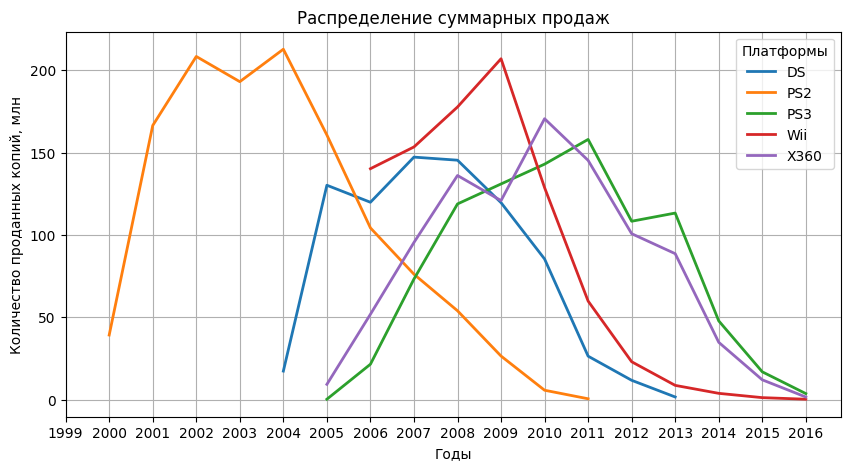

In [21]:
# создание `data_agg` суммарные продажи по годам Топ-5
data_agg = \
(
    data
    .query('(platform in @top5_platforms) and (year_of_release >= 2000)')
    .groupby(['platform', 'year_of_release'])
    .agg({'total_sales': 'sum'})
    .reset_index()
)
# переименование столбцов `data_agg`
data_agg.columns = ['platform', 'year_of_release', 'total_sales']

# построение графика
plt.figure(figsize=(10, 5))
sns.lineplot(
    x='year_of_release', 
    y='total_sales', 
    data=data_agg,
    hue='platform',
    linewidth=2)

plt.title('Распределение суммарных продаж')
plt.xlabel('Годы')
plt.ylabel('Количество проданных копий, млн')
plt.legend(loc='upper right', title='Платформы')
plt.grid()
plt.xticks(ticks=np.arange(1999, 2017, 1))
plt.show()

Средний "жизненный цикл" Топ-5 платформ примерно **10-11 лет**. 

Оценим средний "жизненный цикл" всех платформ и частоту появления новых платформ.

In [22]:
# создание `data_agg` уникальное количество лет по платформам
data_agg = \
(
    data
    .groupby('platform')['year_of_release']
    .agg(lambda x: x.nunique())
    .reset_index()
)

# вывод среднего количества лет
display(
    Markdown(
        f'Средний "жизненный цикл" платформ: '
        f'**{data_agg["year_of_release"].mean():.1f} лет**'
        )
)

# общее число платформ
n_platform = data['platform'].nunique()

# общее число лет анализа
n_year = data['year_of_release'].nunique()

# средний "жизненный цикл" платформы
avg_live = data_agg["year_of_release"].mean()

# частота появления платформ
frequency_platforms = (n_platform / n_year) * (1 / avg_live)
display(
    Markdown(
        f'Частота появления платформ: '
        f'**{frequency_platforms:.1f}** платформ в год'
        )
)

Средний "жизненный цикл" платформ: **7.8 лет**

Частота появления платформ: **0.1** платформ в год

<div style="border:solid gray 1px; padding: 20px">

**Выводы:** 
1. Учитывая средний "жизненный цикл" платформы **7.8 лет** и [анализ выпуска игр по годам (п.3.1)](#analysis_year) установим актуальный период для дальнейшего анализа с **2014 по 2016 гг.**
2. Анализ данных за этот период поможет построить прогноз на 2017 год
3. С учетом средней продолжительности существования игровой платформы, в год появляется **0.1** новых платформ


<a id="sales_platform"></a>
### Анализ продаж по платформам в актуальном периоде

Проанализируем количество суммарных продаж по платформам в период с **2014 по 2016 гг**. Исключим из анализа предыдущие годы.

In [23]:
# оставляем в `data` данные c 2014 года
data = data.query('year_of_release >= 2014')

Оценим количество суммарных продаж по платформам

In [24]:
# создание `data_agg` с агрегированными данными
data_agg = \
(
    data
    .groupby('platform')
    .agg({'total_sales': 'sum'})
    .reset_index()
)
# переименование столбцов `data_agg`
data_agg.columns = ['platform', 'total_sales']

# вывод 10-ти строк отсортированного датафрейма
display(
    data_agg
    .sort_values(by='total_sales', ascending=False)
    .head(10)
)

,platform,total_sales
3,PS4,288.15
9,XOne,140.36
0,3DS,86.68
2,PS3,68.18
8,X360,48.22
7,WiiU,42.98
1,PC,27.40
5,PSV,22.40
6,Wii,5.07
4,PSP,0.36


Сохраним Топ-8 для дальнейшего использования

In [25]:
# запись анализируемых платформ в `top8_platforms`
top8_platforms = data_agg.query('total_sales > 20')['platform']

Построим линейные графики распределения количества суммарных продаж по платформам и по годам.

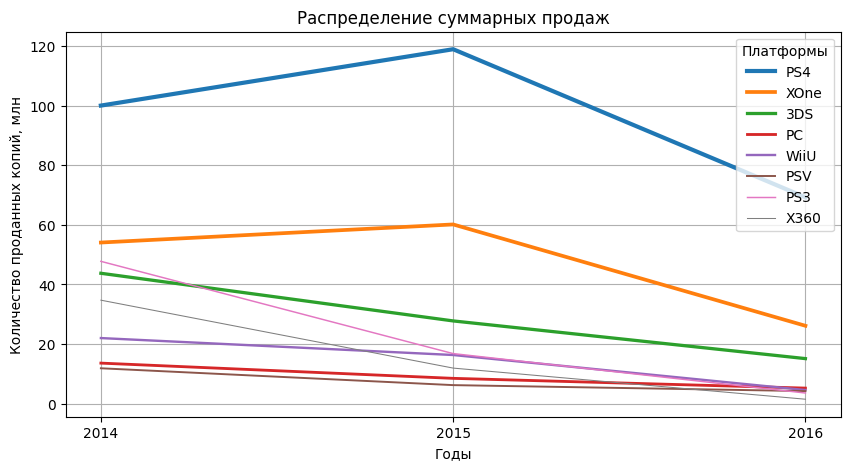

In [26]:
# создание `data_agg` суммарные продажи по годам
data_agg = \
(
    data
    .query('platform in @top8_platforms')
    .groupby(['platform', 'year_of_release'])
    .agg({'total_sales': 'sum'})
    .reset_index()
    .sort_values(by=['year_of_release', 'total_sales'], ascending=False)
)
# переименование столбцов `data_agg`
data_agg.columns = ['platform', 'year_of_release', 'total_sales']

# построение графика
plt.figure(figsize=(10, 5))
palette = sns.color_palette(n_colors=8)
sns.lineplot(
    x='year_of_release', 
    y='total_sales', 
    data=data_agg,
    hue='platform',
    size='platform',
    palette=palette,
    linewidth=5)

plt.title('Распределение суммарных продаж')
plt.xlabel('Годы')
plt.ylabel('Количество проданных копий, млн')
plt.legend(loc='upper right', title='Платформы')
plt.grid()
plt.xticks(ticks=np.arange(2014, 2017, 1))
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:**(с учетом неполных данных за 2016 г.)
1. По продажам лидируют платформы: **PS4, XOne, 3DS**
2. Растущие и потенциально прибыльные платформы: **PS4, XOne**
3. Снижающиеся, но потенциально актуальные платформы в 2017 году: **3DS, PC, WiiU**

### Анализ "диаграм размаха" продаж по платформам

Построим диаграммы "ящик с усами" глобальных продаж по Топ-10 платформам

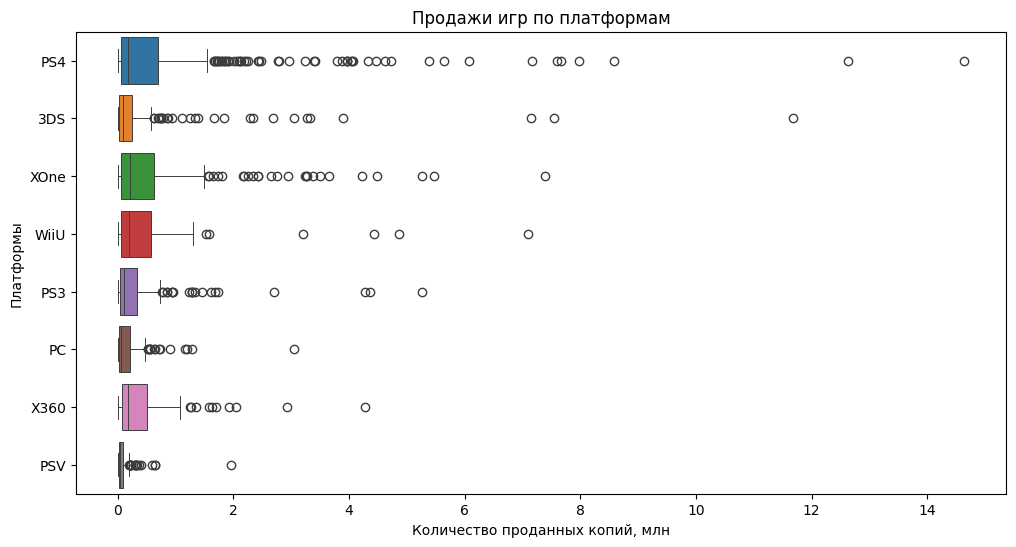

In [27]:
# формирование датафрейма с Топ-6 платформами
data_filtered = \
(
    data
    .query('platform in @top8_platforms')
    .sort_values(by=['year_of_release', 'total_sales'], ascending=False)
)

# вывод графика
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=data_filtered,
    x='total_sales',
    y='platform',
    linewidth=.7,
    hue='platform',
    palette=palette
)
plt.title('Продажи игр по платформам')
plt.ylabel('Платформы')
plt.xlabel('Количество проданных копий, млн')
plt.show()

Рассмотрим подробнее распределение по квартилям. Для этого исключим отображение выбросов на графике.

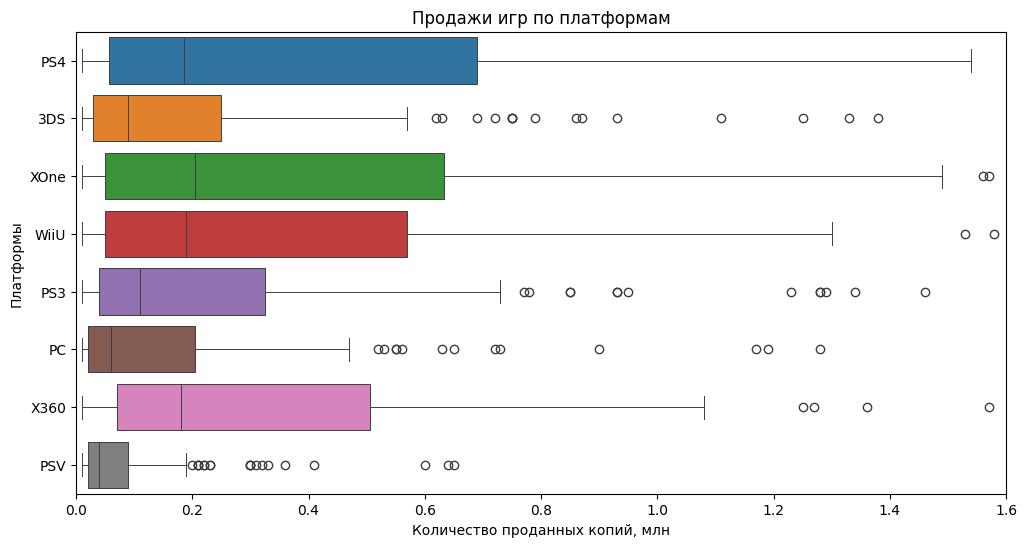

In [28]:
# вывод графика
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=data_filtered,
    x='total_sales',
    y='platform',
    linewidth=.7,
    hue='platform',
    palette=palette
)
plt.title('Продажи игр по платформам')
plt.ylabel('Платформы')
plt.xlabel('Количество проданных копий, млн')
plt.xlim(0,1.6)
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:** 
1. Распределения количества проданных игр имеют длинный хвост выбросов в сторону больших значений по основным популярным платформам. Вероятно это связано с наличием бестселлеров игр в каждой платформе.
2. Количество продаж бестселлеров увеличивают средние значения по каждой платформе, делая их больше медианных значений
3. Медианные значения, сдвинутые в сторону меньших значений, свидетельствуют о большом количество игр с относительно маленьким количеством продаж

<a id="sales_score"></a>
### Зависимость продаж от оценки пользователей и критиков

Проанализируем зависимость количества продаж из `total_sales` от оценки пользователей `user_score` для платформы `PS4`.

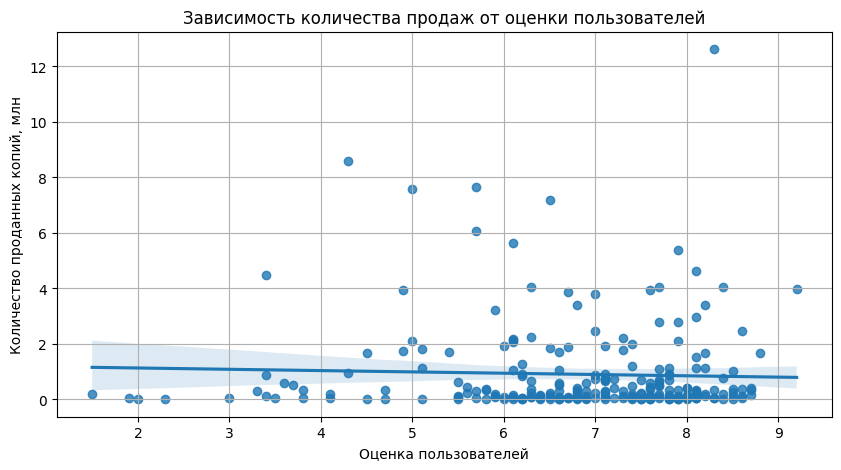

Коэффициент корреляции между количеством продаж и оценкой пользователей: **-0.04**

In [29]:
# формирование датафрейма с данными PS4
data_filtered = \
(
    data
    .query('platform == "PS4"')
)

# вывод графика зависимости между значениями `total_sales` и `user_score`
plt.figure(figsize=(10, 5))
sns.regplot(
    data=data_filtered,
    x='user_score',
    y='total_sales'
)

plt.xlabel('Оценка пользователей')
plt.ylabel('Количество проданных копий, млн')
plt.title('Зависимость количества продаж от оценки пользователей')
plt.grid(True)
plt.show()

# вывод коэффициента корреляции между значениями в `total_sales` и `user_score`
display(
    Markdown(
        f'Коэффициент корреляции между количеством продаж и оценкой пользователей: '
        f'**{data_filtered["total_sales"].corr(data_filtered["user_score"]):.2f}**')
)

Проанализируем зависимость количества продаж из `total_sales` от оценки критиков `critic_score` для платформы `PS4`.

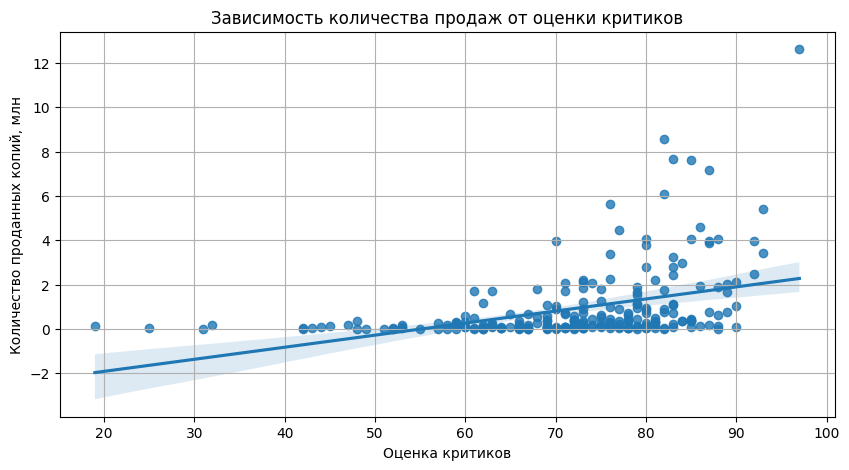

Коэффициент корреляции между количеством продаж и оценкой критиков: **0.40**

In [30]:
# вывод графика зависимости между значениями `total_sales` и `critic_score` без группировки
plt.figure(figsize=(10, 5))
sns.regplot(
    data=data_filtered,
    x='critic_score',
    y='total_sales'
)

plt.xlabel('Оценка критиков')
plt.ylabel('Количество проданных копий, млн')
plt.title('Зависимость количества продаж от оценки критиков')
plt.grid(True)
plt.show()

# вывод коэффициента корреляции между значениями в `total_sales` и `critic_score`
display(
    Markdown(
        f'Коэффициент корреляции между количеством продаж и оценкой критиков: '
        f'**{data_filtered["total_sales"].corr(data_filtered["critic_score"]):.2f}**')
)

Оценим зависимость количества продаж от оценки пользователей и критиков для Топ-10 платформ. Рассчитаем коэффициент корреляции Пирсона:

In [31]:
# расчет коэфф корреляции для каждой платформы из Топ-10 платформ
data_agg = \
(
    data
    .query('platform in @top8_platforms')
    .groupby('platform')[['user_score','critic_score','total_sales']]
    .corr()
    .apply(lambda x: round(x, 2))
    .reset_index()
    .query('level_1 == "total_sales"')
    .drop(columns=['total_sales', 'level_1'])
    .sort_values(by=['user_score', 'critic_score'], ascending=False)
)
data_agg.columns = ['Платформа', 'Корреляция: Продажи / Оценка пользователей', 'Корреляция: Продажи / Оценка критиков']
data_agg

,Платформа,Корреляция: Продажи / Оценка пользователей,Корреляция: Продажи / Оценка критиков
17,WiiU,0.41,0.37
2,3DS,0.22,0.31
11,PS4,-0.04,0.40
23,XOne,-0.07,0.43
5,PC,-0.07,0.18
20,X360,-0.14,0.53
8,PS3,-0.17,0.45
14,PSV,-0.17,0.04


<div style="border:solid gray 1px; padding: 20px">

**Выводы:** 
1. У популярной платформы **PS4**:
    - график зависимости и коэффициент корреляции **-0.04** указывают на отсутствие зависимости между продажами и оценками пользователей
    - график зависимости и коэффициент корреляции **0.4** указывают на умеренную положительную связь между продажами и оценками критиков
2. Зависимость продаж от оценки пользователей у Топ-10 платформ различаются. Вероятно это связано с наличием в некоторых платформах (например WiiU, 3DS) популярных игр, которые были высоко оценены пользователями
3. Зависимость продаж от оценки критиков у Топ-10 платформ примерно одинаковая - умеренно положительная
4. Оценки критиков сильнее влияют на продажи чем оценки пользователей
5. Вероятно большой процент (**40%** в оценках пользователей и **53%** в оценках критиков) отсутствующих данных исказил результаты исследования
6. Выбросы на графиках указывают на влияние и других факторов на суммарные продажи

<a id="sales_genre"></a>
### Распределение игр по жанрам

Проанализируем распределение игр по количеству и продажам в зависимости о жанра на столбчатой диаграмме.

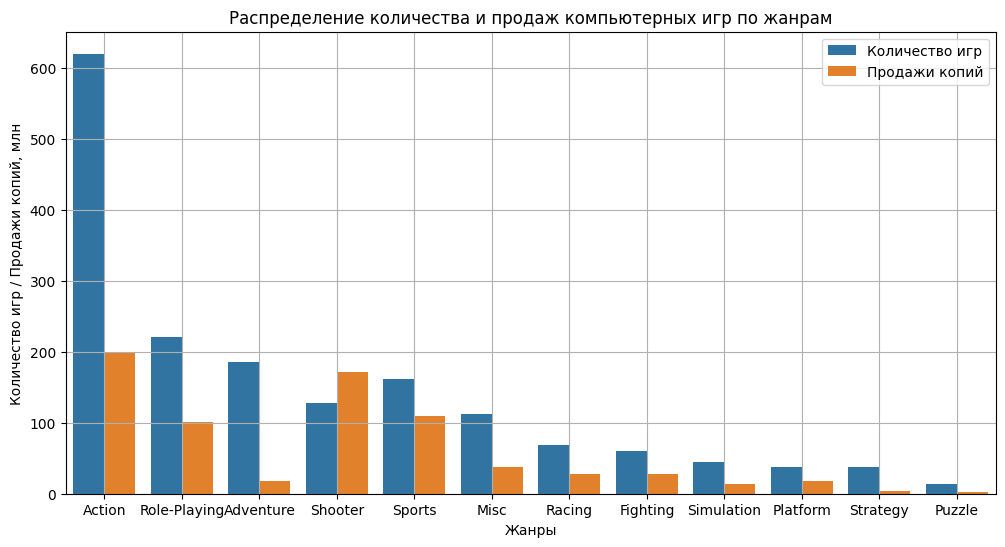

In [32]:
# создание `data_agg` суммарные продажи по жанрам
data_agg = \
(
    data
    .groupby('genre')
    .agg({'total_sales': ['count', 'sum']})
    .reset_index()
)

# переименование столбцов `data_agg`
data_agg.columns = ['Жанры', 'Количество игр', 'Продажи копий']

# преобразование data_agg для отображения
melted_table = \
(
    data_agg
    .melt(id_vars='Жанры', var_name='метрика', value_name='значение')
    .sort_values(by='значение', ascending=False)
)

# вывод графика 
plt.figure(figsize=(12, 6))
sns.barplot(x='Жанры', y='значение', hue='метрика', data=melted_table)
plt.xlabel('Жанры')
plt.ylabel('Количество игр / Продажи копий, млн')
plt.title('Распределение количества и продаж компьютерных игр по жанрам')
plt.grid()
plt.legend(loc='upper right')
plt.show()

<a id="boxplot_genre"></a>
Построим "диаграмму размаха" количества продаж игр по жанрам.

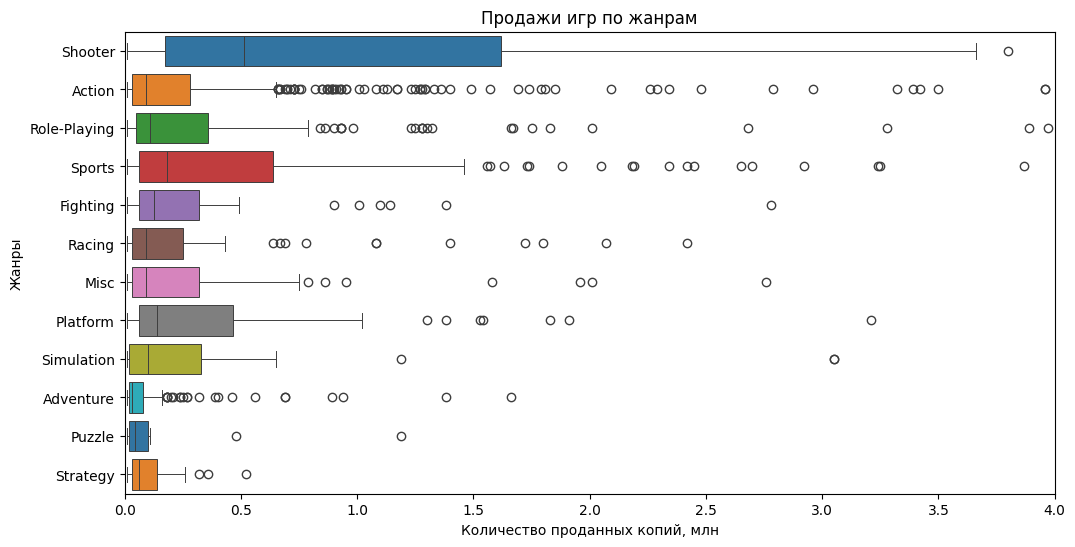

In [33]:
# вывод графика
palette = sns.color_palette(n_colors=12)
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=data,
    x='total_sales',
    y='genre',
    linewidth=.7,
    hue='genre',
    palette=palette
)
plt.title('Продажи игр по жанрам')
plt.ylabel('Жанры')
plt.xlabel('Количество проданных копий, млн')
plt.xlim(0,4)
plt.show()

Оценим "Прибыльность" Топ-5 жанров как отношение количества проданных копий к количеству созданных игр в жанре.

In [34]:
# добавление столбца "Прибыльность" и сортировка
data_agg['Прибыльность'] = round(data_agg['Продажи копий'] / data_agg['Количество игр'], 2)

# вывод на экран отсортированного data_agg
(
    data_agg
    .drop(columns=['Количество игр', 'Продажи копий'])
    .sort_values(by='Прибыльность', ascending=False)
    .head()
)

,Жанры,Прибыльность
8,Shooter,1.34
10,Sports,0.68
4,Platform,0.48
2,Fighting,0.47
7,Role-Playing,0.46


<div style="border:solid gray 1px; padding: 20px">

**Выводы:** 
1. Общая тенденция - чем больше количество игр в жанре, тем больше проданных копий
2. Исключение - жанры "Shooter" и "Sports", в которых преобладают продажи бестселлеров ([смотри "диаграмму размаха"](#boxplot_genre))
3. Самые прибыльные жанры: **Shooter, Sports**
   - у них самое высокое соотношение количества проданных копий к количеству игр
   - игры в данных жанрах могут пользоваться большим спросом и приносить больше прибыли разработчикам и издателям
4. Жанры с большим количеством продаж: **Action, Shooter**
5. Жанры с низким количеством продаж (они же и самые малоприбыльные): **Strategy, Puzzle, Adventure**

<a id="regions"></a>
## Анализ регионов (NA, EU, JP)

<a id="factors"></a>
### Определение популярных платформ

Проанализируем количество продаж Топ-5 платформ в каждом регионе. Оценим количество и доли продаж каждой платформы на графиках.

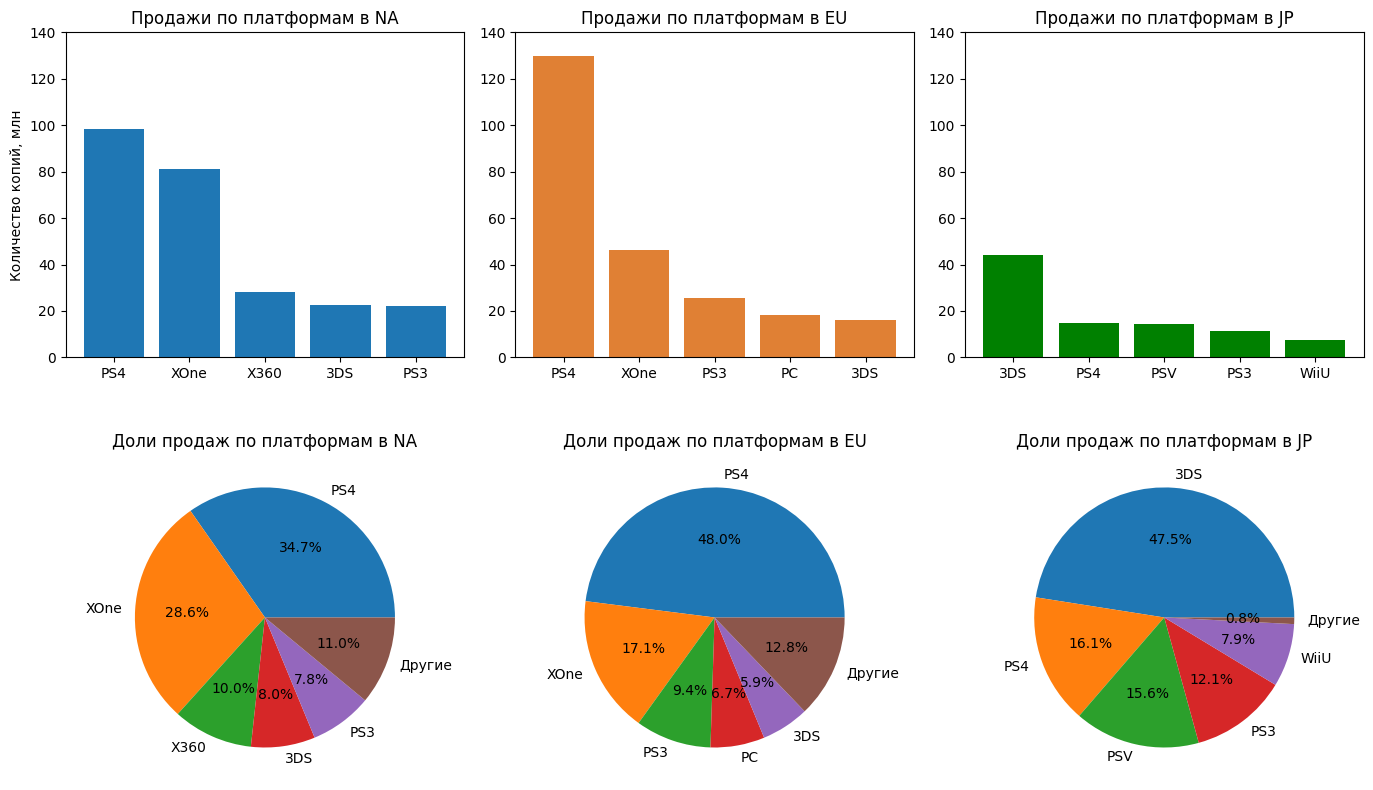

Количество продаж в NA: **284 млн** копий с долей **43.8%** 

Количество продаж в EU: **271 млн** копий с долей **41.8%** 

Количество продаж в JP: **93 млн** копий с долей **14.4%** 



In [35]:
# создание функции для вывода графиков и сводных данных
def top_charts(agg_name, title_name):
    # создание `data_agg` суммарные продажи по платформам
    data_agg = data.groupby(agg_name).agg({
        'na_sales': 'sum',
        'eu_sales': 'sum',
        'jp_sales': 'sum'
    }).reset_index()
    
    # определение топ-5 платформ по продажам для каждого региона
    top_n = 5
    top_platforms_na = data_agg.nlargest(top_n, 'na_sales')
    top_platforms_eu = data_agg.nlargest(top_n, 'eu_sales')
    top_platforms_jp = data_agg.nlargest(top_n, 'jp_sales')
    
    # определение "других" платформ
    other_na_sales = \
    (
        data_agg[~data_agg[agg_name].isin(top_platforms_na[agg_name])]
        .sum().to_frame().T
    )
    other_na_sales[agg_name] = 'Другие'
    
    other_eu_sales = \
    (
        data_agg[~data_agg[agg_name].isin(top_platforms_eu[agg_name])]
        .sum().to_frame().T
    )
    other_eu_sales[agg_name] = 'Другие'
    
    other_jp_sales = \
    (
        data_agg[~data_agg[agg_name].isin(top_platforms_jp[agg_name])]
        .sum().to_frame().T
    )
    other_jp_sales[agg_name] = 'Другие'
    
    # добавление "других" платформ в топ-5
    final_na = pd.concat([top_platforms_na, other_na_sales], ignore_index=True)
    final_eu = pd.concat([top_platforms_eu, other_eu_sales], ignore_index=True)
    final_jp = pd.concat([top_platforms_jp, other_jp_sales], ignore_index=True)

    # создание матрицы диаграмм
    fig, axs = plt.subplots(2, 3, figsize=(14, 8))

    # определение предела оси Y
    max_y = max(final_na['na_sales'].max(),
                final_eu['eu_sales'].max(),
                final_jp['jp_sales'].max()) + 10
    
    # столбчатая диаграмма для NA
    axs[0,0].bar(final_na[agg_name][:5], final_na['na_sales'][:5], color=sns.color_palette()[0])
    axs[0,0].set_title(f'Продажи по {title_name} в NA')
    axs[0,0].set_ylabel('Количество копий, млн')
    axs[0,0].set_ylim(0, max_y)
    
    # столбчатая диаграмма для EU
    axs[0,1].bar(final_eu[agg_name][:5], final_eu['eu_sales'][:5], color='#E08034')
    axs[0,1].set_title(f'Продажи по {title_name} в EU')
    axs[0,1].set_ylabel('')
    axs[0,1].set_ylim(0, max_y)
    
    # столбчатая диаграмма для JP
    axs[0,2].bar(final_jp[agg_name][:5], final_jp['jp_sales'][:5], color='green')
    axs[0,2].set_title(f'Продажи по {title_name} в JP')
    axs[0,2].set_ylabel('')
    axs[0,2].set_ylim(0, max_y)

    # круговая диаграмма для NA
    axs[1,0].pie(final_na['na_sales'], labels=final_na[agg_name], autopct='%1.1f%%', colors=plt.cm.tab10.colors)
    axs[1,0].set_title(f'Доли продаж по {title_name} в NA')
    
    # круговая диаграмма для EU
    axs[1,1].pie(final_eu['eu_sales'], labels=final_eu[agg_name], autopct='%1.1f%%', colors=plt.cm.tab10.colors)
    axs[1,1].set_title(f'Доли продаж по {title_name} в EU')
    
    # круговая диаграмма для JP
    axs[1,2].pie(final_jp['jp_sales'], labels=final_jp[agg_name], autopct='%1.1f%%', colors=plt.cm.tab10.colors)
    axs[1,2].set_title(f'Доли продаж по {title_name} в JP')
    
    # настройка внешнего вида графиков
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    plt.show()

    # возврат итоговых сумм 
    return sum(data_agg["na_sales"]), sum(data_agg["eu_sales"]), sum(data_agg["jp_sales"])

# вызов функции формирования графиков и расчета итоговых сумм
na_sum, eu_sum, jp_sum = top_charts('platform', 'платформам')

# вывод информации о продажах
display(
    Markdown(
        f'Количество продаж в NA: '
        f'**{na_sum:.0f} млн** копий '
        f'с долей **{na_sum / (na_sum + eu_sum + jp_sum):.1%}** \n\n'
        f'Количество продаж в EU: '
        f'**{eu_sum:.0f} млн** копий '
        f'с долей **{eu_sum / (na_sum + eu_sum + jp_sum):.1%}** \n\n'
        f'Количество продаж в JP: '
        f'**{jp_sum:.0f} млн** копий '
        f'с долей **{jp_sum / (na_sum + eu_sum + jp_sum):.1%}** \n\n'
    )
)

<div style="border:solid gray 1px; padding: 20px">

**Выводы:**

1. Платформы **PS4** и ее предыдущая версия **PS3** популярна во всех регионах
5. Платформы - лидеры по продажам:
   - в NA и EU - **PS4**
   - в JP - **3DS**
6. Платформа **X360** популярна только в NA
7. Платформа **РС** популярна только в EU
8. Платформы **PSV, WiiU** популярны только в JP

<a id="create_data"></a>
### Определение популярных жанров

Проанализируем количество продаж Топ-5 жанров в каждом регионе. Оценим количество и доли продаж каждого жанра на графиках.

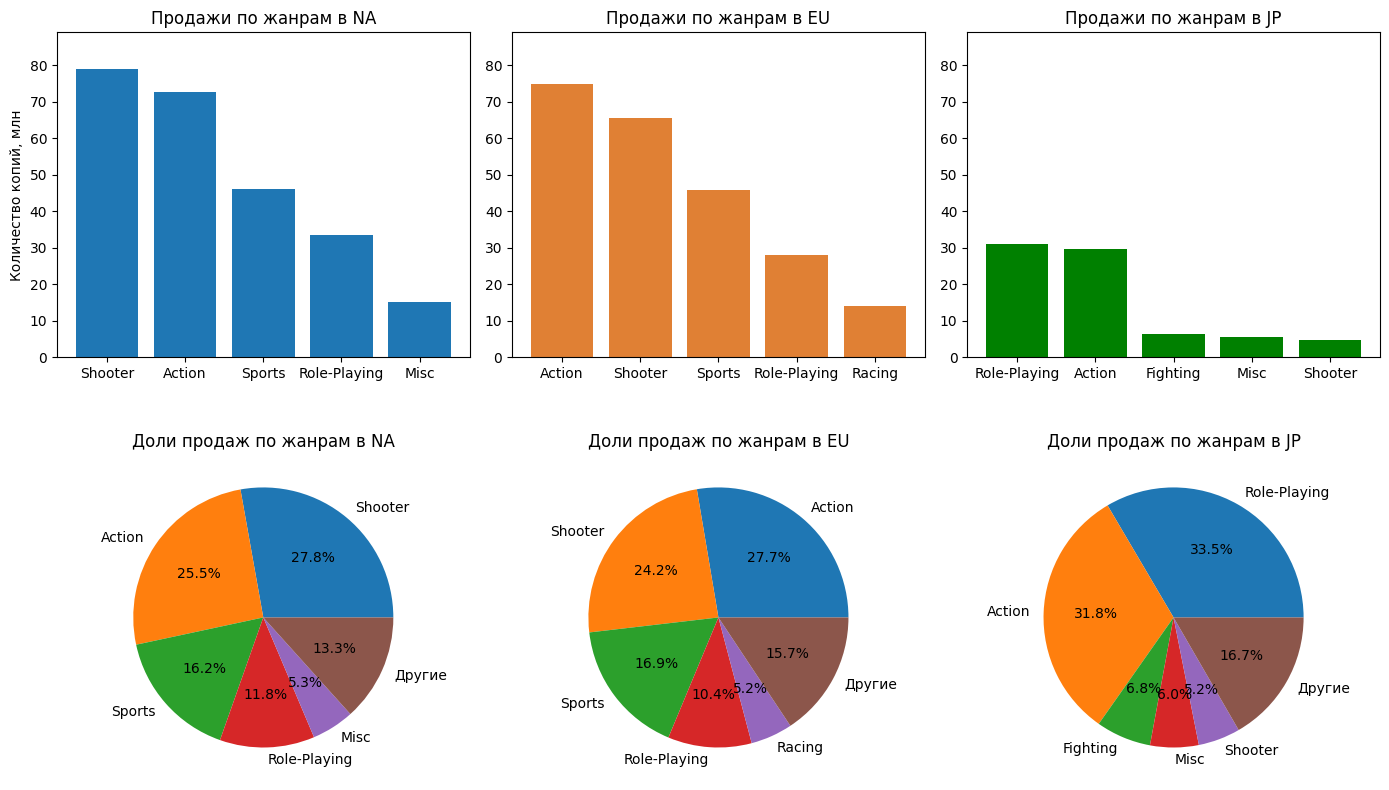

In [36]:
# вызов функции формирования графиков
top_charts('genre', 'жанрам');

<div style="border:solid gray 1px; padding: 20px">

**Вывод:**

1. Общие предпочтения по жанрам для всех регионов:
   - Action **25-30%**
   - Shooter **5-28%**
3. Предпочтения по жанрам в NA и EU практически одинаковые - с почти одинаковым распеределением долей по количеству продаж:
   - Action **25-27%**
   - Shooter **24-27%**
   - Sports **~16%**
4. В JP распределение интересов по жанрам отличается от NA & EU:
   - Role-Playing **34%**
   - только в JP - Fighting **7%**  

### Влияние рейтинга ESRB на продажи в регионах


Проанализируем диапазон значений в столбце `rating`

In [37]:
# количество игр по рейтингу
data['rating'].value_counts()

rating
M       309
T       301
E       227
E10+    198
Name: count, dtype: int64

Для удобства анализа расшифруем категории рейтинга и сделаем замены:
- учитывая что рейтинг "ЕС" заменяется на "Е" с 01.03.2018, сделаем такую же замену в данных
- рейтинг "RP" у Supreme Ruler Cold War заменим на текущий рейтинг "E10+"

In [38]:
# создание словаря для замены буквы рейтинга на название
rating_dict = {
    'E': 'Для всех', 
    'T': 'Подросткам 13+', 
    'M': 'Для взрослых 17+', 
    'E10+': 'Для всех 10+', 
    'EC': 'Для всех', 
    'RP': 'Для всех 10+'
}

# замена букв рейтинга на названия
data['rating'] = data['rating'].map(rating_dict)

Проанализируем распределение продаж игр в зависимости от рейтинга и региона на столбчатых диаграммах.

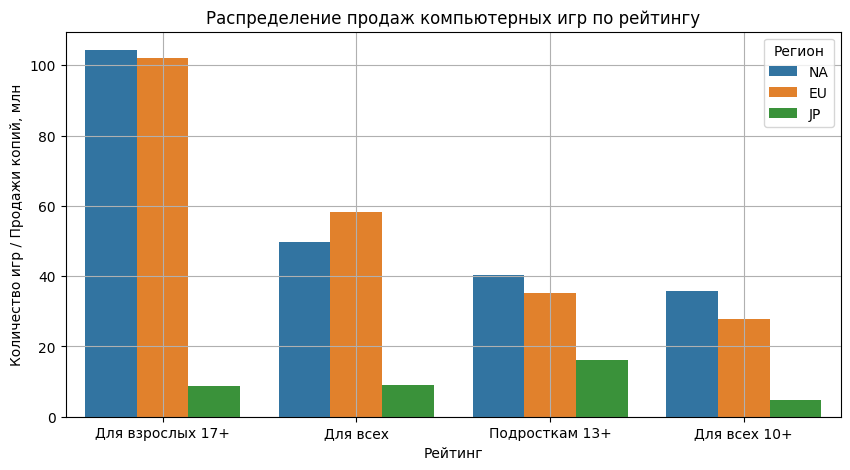

In [44]:
# создание `data_agg` продажи по рейтингу
data_agg = \
(
    data
    .groupby('rating')
    .agg({'na_sales': 'sum',
          'eu_sales': 'sum',
          'jp_sales': 'sum'})
    .reset_index()
)

# переименование столбцов `data_agg`
data_agg.columns = ['Рейтинг', 'NA', 'EU', 'JP']

# преобразование data_agg для отображения
melted_table = \
(
    data_agg
    .melt(id_vars='Рейтинг', var_name='метрика', value_name='значение')
    .sort_values(by='значение', ascending=False)
)

# вывод графика 
plt.figure(figsize=(10, 5))
sns.barplot(
    x='Рейтинг', 
    y='значение', 
    hue='метрика',
    data=melted_table
)
plt.xlabel('')
plt.ylabel('Количество игр / Продажи копий, млн')
plt.xlabel('Рейтинг')
plt.title('Распределение продаж компьютерных игр по рейтингу')
plt.grid()
plt.legend(loc='upper right', title='Регион')
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:**

1. Распределение продаж по рейтингу ESRB в регионах NA и EU практически одинаковое:
   - лидируют игры с рейтингом "Для взрослых 17+" вероятно из-за более зрелой аудитории игроков в этих регионах
   - вторая по популярности категория "Для всех" - из-за универсальной привлекательности для игроков различных возрастов и предпочтений
   - игра для детей "Для всех 10+" и игры "Подросткам 13+" делят третье место
2. В регионе JP ситуация другая:
   - лидирует категория игр "Подросткам 13+"
   - второе место делят игры "Для всех" и  "Для взрослых 17+"
   - сильно отстают продажи в категории для детей "Для всех 10+" вероятно из-за более жестких правил ограничения контента в JP

<a id="testing_hypos"></a>
## Проверка гипотез

Оценим пользовательские рейтинги двух платформ и пользовательские рейтинги двух жанров

### Гипотеза о рейтингах двух платформ

Выясним, одинаковые ли средние пользовательские рейтинги платформ Xbox One и PC.


**H0** - нулевая гипотеза:
- средние пользовательские рейтинги платформ одинаковые

**H1** - альтернативная двусторонняя гипотеза
- средние пользовательские рейтинги платформ различаются

Проверим гипотезу с помощью Т-критерия Стьюдента для независимых выборок. Если вероятность ошибочно отвергнуть нулевую гипотезу `p-value` окажется меньше уровня статистической значимости `alpha = 5%`, то отвергнем нулевую гипотезу в пользу альтернативной.

Оценим графически распределение средних оценок пользователей, например **по рейтингу ESRB**.

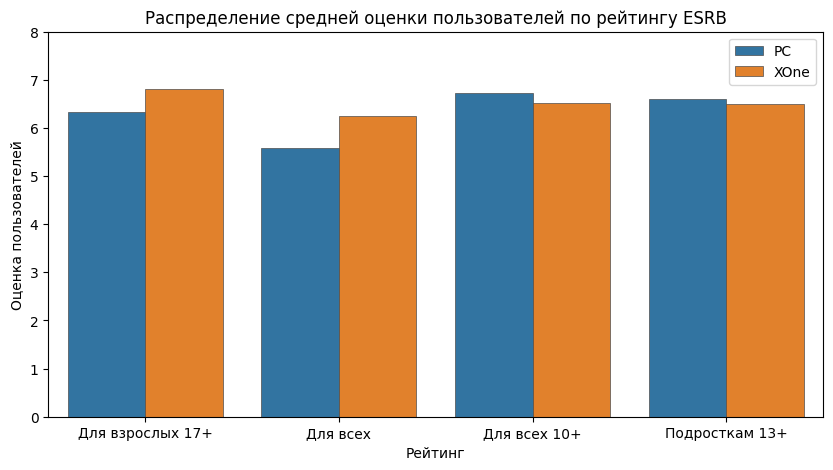

In [40]:
# создание сводной таблицы для графика
data_agg = \
(
    data
    .query('(platform == "XOne" | platform == "PC")')
    .groupby(['rating', 'platform'])
    .agg({'user_score': 'mean'})
    .reset_index()
)

# вывод столбчатой диаграммы для `df_agg`
plt.figure(figsize=(10, 5))
sns.barplot(
    data=data_agg,
    x="rating",
    y="user_score",
    edgecolor=".3",
    linewidth=.5,
    hue='platform'
)
plt.title('Распределение средней оценки пользователей по рейтингу ESRB')
plt.ylabel('Оценка пользователей')
plt.xlabel('Рейтинг')
plt.ylim(0,8)
plt.legend()
plt.show()

Визуальная оценка - средние оценки пользователей платформ XOne и PC примерно равны. Проверим гипотезу t-тестом.

In [41]:
# создание таблиц  для двух платформ
data_xone = data.query('(platform == "XOne") and (user_score.notna())')
data_pc = data.query('(platform == "PC") and (user_score.notna())')

# задание уровня статистической значимости
alpha = 0.05

# выполнение t-теста с двусторонней альтернативной гипотезой
t_stat, p_value = st.ttest_ind(data_xone['user_score'], data_pc['user_score'])

# проверка гипотезы
if p_value < alpha:
    display(
        Markdown(
            f'p_value=**{p_value:.2e}** < {alpha:.2%}\n\n'
            f' Отвергаем нулевую гипотезу: средние пользовательские рейтинги платформ различаются.'
        )
    )
else:
    display(
        Markdown(
            f'p_value=**{p_value:.2%}** >= {alpha:.2%}\n\n'
            f' Не удалось отвергнуть нулевую гипотезу: нет достаточных доказательств,\
            что средние пользовательские рейтинги платформ различаются.'
        )
    )

p_value=**12.69%** >= 5.00%

 Не удалось отвергнуть нулевую гипотезу: нет достаточных доказательств,            что средние пользовательские рейтинги платформ различаются.

<div style="border:solid gray 1px; padding: 20px">

**Вывод:** 

1. Средние пользовательские рейтинги платформ Xbox One и PC **одинаковые**

### Гипотеза о рейтингах двух жанров

Выясним, одинаковые ли средние пользовательские рейтинги жанров Action и Sports.


**H0** - нулевая гипотеза:
- средние пользовательские рейтинги жанров одинаковые

**H1** - альтернативная двусторонняя гипотеза
- средние пользовательские рейтинги жанров различаются

Проверим гипотезу с помощью Т-критерия Стьюдента для независимых выборок. Если вероятность ошибочно отвергнуть нулевую гипотезу `p-value` окажется меньше уровня статистической значимости `alpha = 5%`, то отвергнем нулевую гипотезу в пользу альтернативной.

Оценим графически распределение средних оценок пользователей, например **по платформам**.

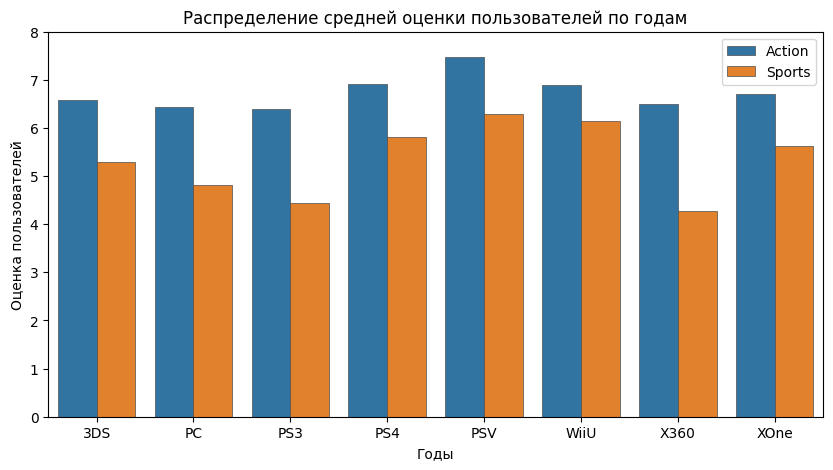

In [42]:
# создание сводной таблицы для графика
data_agg = \
(
    data
    .query('(genre == "Action" | genre == "Sports")')
    .groupby(['platform', 'genre'])
    .agg({'user_score': 'mean'})
    .reset_index()
)
data_agg = data_agg.query('user_score.notna() and platform != "Wii"')

# вывод столбчатой диаграммы для `df_agg`
plt.figure(figsize=(10, 5))
sns.barplot(
    data=data_agg,
    x="platform",
    y="user_score",
    edgecolor=".3",
    linewidth=.5,
    hue='genre'
)
plt.title('Распределение средней оценки пользователей по годам')
plt.ylabel('Оценка пользователей')
plt.xlabel('Годы')
plt.ylim(0,8)
plt.legend()
plt.show()

Визуальная оценка - средние оценки пользователей жанров Action и Sports различаются. Проверим гипотезу t-тестом.

In [43]:
# создание таблиц  для двух платформ
data_action = data.query('(genre == "Action") and (user_score.notna())')
data_sports = data.query('(genre == "Sports") and (user_score.notna())')

# задание уровня статистической значимости
alpha = 0.05

# выполнение t-теста с двусторонней альтернативной гипотезой
t_stat, p_value = st.ttest_ind(data_action['user_score'], data_sports['user_score'])

# проверка гипотезы
if p_value < alpha:
    display(
        Markdown(
            f'p_value=**{p_value:.2e}** < {alpha:.2%}\n\n'
            f' Отвергаем нулевую гипотезу: средние пользовательские рейтинги жанров различаются.'
        )
    )
else:
    display(
        Markdown(
            f'p_value=**{p_value:.2%}** >= {alpha:.2%}\n\n'
            f' Не удалось отвергнуть нулевую гипотезу: нет достаточных доказательств,\
            что средние пользовательские рейтинги жанров различаются.'
        )
    )

p_value=**2.12e-19** < 5.00%

 Отвергаем нулевую гипотезу: средние пользовательские рейтинги жанров различаются.

<div style="border:solid gray 1px; padding: 20px">

**Вывод:** 

1. Средние пользовательские рейтинги жанров Action и Sports **различаются**

<a id="research_results"></a>
## Итоги исследования

В результате исследования отработаны принципы работы с данными о компьютерных играх и выявлены закономерности, определяющие их успешность. Обнаруженные закономерности позволят сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Установлено**:


1. Для прогноза на 2017 год лучше использовать данные в период с **2014 по 2016** гг.
2. Продажи по платформам
   - лидируют платформы: **PS4, XOne, 3DS**
   - из них растущие и потенциально прибыльные: **PS4, XOne**
   - снижающиеся, но пока актуальные платформы в 2017 году: **3DS, PC, WiiU**
   - во всех платформах есть бестселлеры с большим количеством продаж и много игр с относительно маленьким количеством продаж
3.  Зависимость продаж от оценки пользователей/критиков:
    - зависимость от оценки пользователей у Топ-10 платформ различаются. Вероятно это связано с наличием в некоторых платформах (например WiiU, 3DS) популярных игр или с большим процентом (**40%**) отсутствующих данных
    - зависимость от оценки критиков у Топ-10 платформ примерно одинаковая - умеренно положительная
4. Продажи по жанрам
   - самые прибыльные жанры: **Shooter, Sports**
   - жанры с большим количеством продаж: **Action, Shooter**
   - жанры с низким количеством продаж (они же и самые малоприбыльные): **Strategy, Puzzle, Adventure**
6. Про регионы NA, EU, JP
   - платформа **PS4** и ее предыдущая версия **PS3** популярна во всех регионах
   - платформы - лидеры по продажам: в NA и EU - **PS4**, в JP - **3DS**
   - платформа **X360** популярна только в NA
   - платформа **РС** популярна только в EU
   - платформы **PSV, WiiU** популярны только в JP
   - общие предпочтения по жанрам для всех регионов: **Action, Shooter**
   - предпочтения по жанрам в NA и EU практически одинаковые, а в JP распределение интересов по жанрам отличается от NA & EU
   - распределение продаж по рейтингу **ESRB** в регионах NA и EU практически одинаковое - лидируют игры с рейтингом **"Для взрослых 17+"**, а в JP ситуация другая - лидируют игры **"Подросткам 13+"**
8. Средние пользовательские рейтинги платформ Xbox One и PC **одинаковые**
9. Средние пользовательские рейтинги жанров Action и Sports **различаются**
   
**Рекомендации**:

1. Увеличить процент собираемости информации об оценках пользователей/критиков и рейтинга ESRB
2. Провести дополнительное исследование зависимости продаж от оценки пользователей/критиков и рейтинга ESRB после обогащения данных
3. Проверить гипотезу о снижении "жизненного цикла" платформ
4. Провести анализ продаж в "Другом" регионе (текущая доля от всех продаж **11%**)
5. Провести анализ изменения продаж по годам в жанрах
6. Оценить изменение предпочтений пользователей/критиков по годам

[Вернуться в начало](#intro)